In [172]:
##This is a pytorch implement for HybridSN 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import spectral
import random
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from scipy.io import loadmat
import os
from tqdm.notebook import tqdm
%matplotlib inline

In [173]:
##hypeperameters and experimental settings
RANDOM_SEED=666
DATASET = 'SA'    ## PU  IP  SA  
TRAIN_RATE = 0.3  ## ratio of training data
VAL_RATE = 0.1    ## ratio of valuating data
EPOCH = 100    ##number of epoch
VAL_EPOCH = 5  ##interval of valuation
LR = 0.001    ##learning rate
WEIGHT_DECAY = 1e-6  
BATCH_SIZE = 256
DEVICE = 0  ##-1:CPU  0:cuda 0
N_PCA = 15  ## reserved PCA components
PATCH_SIZE = 25 
SAVE_PATH = f"results\\{DATASET}"
if not os.path.isdir(SAVE_PATH):
    os.mkdir(SAVE_PATH)

In [174]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [175]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'dataset')
    if name == 'IP':
        data = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = loadmat(os.path.join(data_path, 'IndianPines\\Indian_pines_gt.mat'))['indian_pines_gt']
        class_name = [ "Alfalfa", "Corn-notill", "Corn-mintill","Corn", "Grass-pasture", 
                       "Grass-trees","Grass-pasture-mowed", "Hay-windrowed", "Oats","Soybean-notill", "Soybean-mintill", "Soybean-clean","Wheat", "Woods", "Buildings-Grass-Trees-Drives","Stone-Steel-Towers"]
    elif name == 'SA':
        data = loadmat(os.path.join(data_path, 'Salinas\\Salinas_corrected.mat'))['salinas_corrected']
        labels = loadmat(os.path.join(data_path, 'Salinas\\Salinas_gt.mat'))['salinas_gt']
        class_name = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow',
                        'Fallow_rough_plow','Fallow_smooth','Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green','Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk','Vinyard_untrained','Vinyard_vertical']
    elif name == 'PU':
        data = loadmat(os.path.join(data_path, 'PaviaU\\PaviaU.mat'))['paviaU']
        labels = loadmat(os.path.join(data_path, 'PaviaU\\PaviaU_gt.mat'))['paviaU_gt']
        class_name = ['Asphalt', 'Meadows', 'Gravel', 'Trees','Painted metal sheets', 'Bare Soil', 
                      'Bitumen','Self-Blocking Bricks', 'Shadows']
    return data, labels, class_name


In [176]:
data,label,class_name = loadData(DATASET)
NUM_CLASS = label.max()

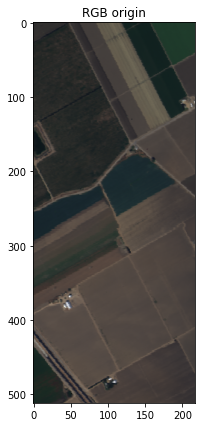

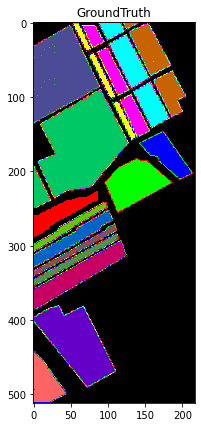

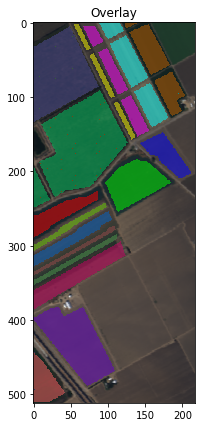

In [177]:
## display HSI
rgb_view=spectral.imshow(data,(30,20,10),classes=label,title='RGB origin',figsize=(7,7))
gt_view = spectral.imshow(classes=label, title='GroundTruth',figsize=(7,7))
view = spectral.imshow(data,(30,20,10),classes=label,figsize=(7,7))
view.set_display_mode('overlay')
view.class_alpha = 0.5
view.set_title('Overlay')
spectral.save_rgb(f'results/{DATASET}_RGB_origin.jpg',data,(30,20,10))
spectral.save_rgb(f'results/{DATASET}_gt.jpg',label,colors = spectral.spy_colors)

In [178]:
## show 3D cube
# %matplotlib auto
# spectral.view_cube(data,(30,20,10))   ## depend on wxpython and pyopengl

In [179]:
def applyPCA(X, numComponents=15):
    """PCA processing

    Args:
        X (ndarray M*N*C): data needs DR
        numComponents (int, optional): number of reserved components. Defaults to 15.

    Returns:
        newX: _description_
    """
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)   ##PCA and normalization
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [180]:
data,pca = applyPCA(data,N_PCA)
data.shape

(512, 217, 15)

In [181]:
def sample_gt(gt, train_rate):
    """ generate training gt for training dataset
    Args:
        gt (ndarray): full classmap
        train_rate (float): ratio of training dataset
    Returns:
        train_gt(ndarray): classmap of training data
        test_gt(ndarray): classmap of test data
    """
    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...])
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels
    y = gt[indices].ravel()
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
    if train_rate > 1:
       train_rate = int(train_rate)
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]]
    test_indices = [t for t in zip(*test_indices)]
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
    
    return train_gt, test_gt

In [182]:
train_gt, test_gt = sample_gt(label,TRAIN_RATE)
val_gt,test_gt = sample_gt(test_gt,VAL_RATE/(1-TRAIN_RATE))

  class   train_num  val_num   test_num   total   
    1        603       201       1205      2009   
    2        1118      372       2236      3726   
    3        593       197       1186      1976   
    4        418       139       837       1394   
    5        803       268       1607      2678   
    6        1188      396       2375      3959   
    7        1074      358       2147      3579   
    8        3381      1127      6763     11271   
    9        1861      620       3722      6203   
    10       983       328       1967      3278   
    11       320       107       641       1068   
    12       578       193       1156      1927   
    13       275        92       549       916    
    14       321       107       642       1070   
    15       2180      727       4361      7268   
    16       542       181       1084      1807   
  total     16238      5413     32478     54129   


ImageView object:
  Interpolation       :  <default>

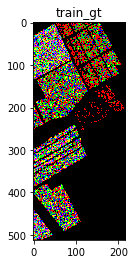

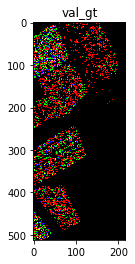

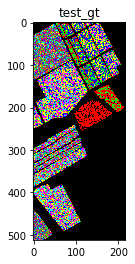

In [183]:
## display sampling info
sample_report = f"{'class': ^10}{'train_num':^10}{'val_num': ^10}{'test_num': ^10}{'total': ^10}\n"
for i in np.unique(label):
    if i == 0: continue
    sample_report += f"{i: ^10}{(train_gt==i).sum(): ^10}{(val_gt==i).sum(): ^10}{(test_gt==i).sum(): ^10}{(label==i).sum(): ^10}\n"
sample_report += f"{'total': ^10}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(val_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(label): ^10}"
print(sample_report)
spectral.imshow(classes=train_gt, title='train_gt')
spectral.imshow(classes=val_gt, title='val_gt')
spectral.imshow(classes=test_gt, title='test_gt')

In [184]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            is_pred: bool, create data without label for prediction (default False) 

        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label


In [185]:
##create dataset and dataloader
train_data = PatchSet(data, train_gt, PATCH_SIZE)
val_data = PatchSet(data, val_gt, PATCH_SIZE)
all_data = PatchSet(data, label, PATCH_SIZE,is_pred = True)
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle= True)
val_loader = DataLoader(val_data,BATCH_SIZE,shuffle= True)
all_loader = DataLoader(all_data,BATCH_SIZE,shuffle= False)

In [186]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([15, 25, 25]), tensor(12))

In [187]:
## Defination of HybridSN
class HybridSN(nn.Module):
    def __init__(self, in_chs, patch_size, class_nums):
        super().__init__()
        self.in_chs = in_chs
        self.patch_size = patch_size
        self.conv1 = nn.Sequential(
                    nn.Conv3d(in_channels=1,out_channels=8,kernel_size=(7, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
                    nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(
                    nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3, 3, 3)),
                    nn.ReLU(inplace=True))
        
        self.x1_shape = self.get_shape_after_3dconv()
        # print(self.x1_shape)
        self.conv4 = nn.Sequential(
                    nn.Conv2d(in_channels=self.x1_shape[1]*self.x1_shape[2],out_channels=64,kernel_size=(3, 3)),
                    nn.ReLU(inplace=True))
        self.x2_shape = self.get_shape_after_2dconv()
        # print(self.x2_shape)
        self.dense1 = nn.Sequential(
                    nn.Linear(self.x2_shape,256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense2 = nn.Sequential(
                    nn.Linear(256,128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense3 = nn.Sequential(
                    nn.Linear(128,class_nums)
                   )
    
    def get_shape_after_2dconv(self):
        x = torch.zeros((1, self.x1_shape[1]*self.x1_shape[2], self.x1_shape[3], self.x1_shape[4]))
        with torch.no_grad():
            x = self.conv4(x)
            print
        return x.shape[1]*x.shape[2]*x.shape[3]
    
    def get_shape_after_3dconv(self):
        x = torch.zeros((1, 1, self.in_chs, self.patch_size, self.patch_size))
        with torch.no_grad():
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
        return x.shape
    
    def forward(self, X):
        X = X.unsqueeze(1)
        x = self.conv1(X)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0],x.shape[1]*x.shape[2],x.shape[3],x.shape[4])
        # print(x.shape)
        x = self.conv4(x)
        x = x.contiguous().view(x.shape[0], -1)
        # print(x.shape)
        x = self.dense1(x)
        x = self.dense2(x)
        out = self.dense3(x)
        return out

net = HybridSN(N_PCA,PATCH_SIZE,class_nums=NUM_CLASS)
summary(net, input_size=(1,N_PCA,PATCH_SIZE,PATCH_SIZE),col_names=['num_params','kernel_size','mult_adds','input_size','output_size'],col_width=10,row_settings=['var_names'],depth=4)

Layer (type (var_name))                  Param #    Kernel Shape Mult-Adds  Input Shape Output Shape
HybridSN                                 --         --         --         --         --
├─Sequential (conv1)                     --         --         --         [1, 1, 15, 25, 25] [1, 8, 9, 23, 23]
│    └─Conv3d (0)                        512        [1, 8, 7, 3, 3] 2,437,632  [1, 1, 15, 25, 25] [1, 8, 9, 23, 23]
│    └─ReLU (1)                          --         --         --         [1, 8, 9, 23, 23] [1, 8, 9, 23, 23]
├─Sequential (conv2)                     --         --         --         [1, 8, 9, 23, 23] [1, 16, 5, 21, 21]
│    └─Conv3d (0)                        5,776      [8, 16, 5, 3, 3] 12,736,080 [1, 8, 9, 23, 23] [1, 16, 5, 21, 21]
│    └─ReLU (1)                          --         --         --         [1, 16, 5, 21, 21] [1, 16, 5, 21, 21]
├─Sequential (conv3)                     --         --         --         [1, 16, 5, 21, 21] [1, 32, 3, 19, 19]
│    └─Conv3d (0)     

Training::   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

epoch 0/100 loss:0.0027104567701745127  acc:0.7649341051853676


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 1/100 loss:0.0001787231236073144  acc:0.9862667816233527


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 2/100 loss:4.42165886714971e-05  acc:0.9964897154822022


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 3/100 loss:5.70044220072573e-05  acc:0.9961817957876585


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 4/100 loss:7.130565017857867e-05  acc:0.9945806133760315


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 4/100  val_acc:0.998522076482542


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 5/100 loss:2.5726687829645675e-05  acc:0.9984604015272817


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 6/100 loss:5.3006775389227123e-05  acc:0.9971055548712896


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 7/100 loss:4.032074386490368e-05  acc:0.9976598103214681


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 8/100 loss:9.192159043037672e-06  acc:0.9995073284887301


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 9/100 loss:1.5844445039506935e-05  acc:0.9989530730385515


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 9/100  val_acc:0.9998152595603178


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 10/100 loss:1.70826070008626e-05  acc:0.9989530730385515


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 11/100 loss:5.928916481550714e-05  acc:0.995873876093115


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 12/100 loss:8.4965653933644e-05  acc:0.9945190294371228


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 13/100 loss:5.392319497761024e-05  acc:0.9970439709323808


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 14/100 loss:1.3971931367997224e-05  acc:0.9988914890996428


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 14/100  val_acc:0.9996305191206355


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 15/100 loss:3.699368217160894e-05  acc:0.998152481832738


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 16/100 loss:6.144404241221253e-06  acc:0.9996920803054563


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 17/100 loss:9.840948345921856e-06  acc:0.9992609927330952


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 18/100 loss:3.363636334766445e-06  acc:0.9996920803054563


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 19/100 loss:5.161038115110737e-06  acc:0.9997536642443651


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 19/100  val_acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 20/100 loss:6.571138687019281e-06  acc:0.9996920803054563


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 21/100 loss:1.6102214468264138e-05  acc:0.999076240916369


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 22/100 loss:4.457331783095255e-06  acc:0.9996304963665475


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 23/100 loss:3.002589043723833e-06  acc:0.9997536642443651


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 24/100 loss:1.9216431817360583e-06  acc:0.9998768321221825


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 24/100  val_acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 25/100 loss:1.6595544563326527e-05  acc:0.9986451533440078


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 26/100 loss:2.5812903813923794e-05  acc:0.9985835694050992


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 27/100 loss:1.8621911183073848e-05  acc:0.9985219854661904


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 28/100 loss:1.9367614415248242e-05  acc:0.9988299051607341


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 29/100 loss:0.00017483418283350486  acc:0.994703781253849


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 29/100  val_acc:0.9981525956031775


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 30/100 loss:0.0005517825627160247  acc:0.9686537750954551


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 31/100 loss:0.0001001417358336317  acc:0.9936568542924006


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 32/100 loss:2.2931578866604896e-05  acc:0.9987683212218254


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 33/100 loss:3.731139853494001e-05  acc:0.9980293139549206


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 34/100 loss:5.3593866912380085e-05  acc:0.9982140657716467


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 34/100  val_acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 35/100 loss:2.18552308730584e-05  acc:0.9987683212218254


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 36/100 loss:1.6632207542551703e-05  acc:0.9991378248552777


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 37/100 loss:8.387765931179274e-05  acc:0.9971671388101983


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 38/100 loss:2.386519333904806e-05  acc:0.9993841606109126


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 39/100 loss:1.5933807665974792e-05  acc:0.999322576672004


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 39/100  val_acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 40/100 loss:4.5371175439772684e-06  acc:0.9998152481832738


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 41/100 loss:6.995418585016923e-06  acc:0.9998152481832738


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 42/100 loss:3.7067296944483243e-06  acc:0.9997536642443651


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 43/100 loss:1.4237112283214764e-05  acc:0.999076240916369


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 44/100 loss:8.714934416497267e-06  acc:0.9993841606109126


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 44/100  val_acc:0.9998152595603178


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 45/100 loss:4.697008891383309e-06  acc:0.9997536642443651


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 46/100 loss:4.710107658154314e-06  acc:0.9998152481832738


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 47/100 loss:2.9084017507663867e-06  acc:0.9996920803054563


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 48/100 loss:4.2342723132197066e-07  acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 49/100 loss:3.727196089197823e-07  acc:0.9999384160610912


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 49/100  val_acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 50/100 loss:6.880440847857654e-07  acc:0.9999384160610912


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 51/100 loss:6.890776168334102e-07  acc:0.9998768321221825


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 52/100 loss:4.18238589794e-06  acc:0.9997536642443651


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 53/100 loss:2.6914954265359617e-05  acc:0.9988914890996428


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 54/100 loss:3.266439456489362e-05  acc:0.9992609927330952


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 54/100  val_acc:0.9998152595603178


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 55/100 loss:0.000331886531882818  acc:0.992856263086587


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 56/100 loss:6.0627026529620095e-05  acc:0.9974750585047419


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 57/100 loss:0.00011396517471795775  acc:0.9977829781992856


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 58/100 loss:4.350280107221522e-05  acc:0.9985835694050992


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 59/100 loss:7.157910945996923e-05  acc:0.998152481832738


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 59/100  val_acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 60/100 loss:0.00014532907602063567  acc:0.9977213942603769


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 61/100 loss:4.077740477919748e-05  acc:0.9988299051607341


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 62/100 loss:2.3312511831987475e-05  acc:0.999076240916369


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 63/100 loss:2.805172291356995e-06  acc:0.9996920803054563


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 64/100 loss:3.178697301346234e-06  acc:0.9996304963665475


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 64/100  val_acc:0.9998152595603178


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 65/100 loss:2.670783742393254e-05  acc:0.9995073284887301


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 66/100 loss:2.0757385665485622e-05  acc:0.9995689124276389


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 67/100 loss:9.490065262746435e-05  acc:0.9982756497105555


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 68/100 loss:4.260798191180349e-05  acc:0.9985219854661904


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 69/100 loss:1.746666729091696e-05  acc:0.9996304963665475


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 69/100  val_acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 70/100 loss:1.0713731221546606e-05  acc:0.9995689124276389


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 71/100 loss:2.160432887675814e-06  acc:0.9998768321221825


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 72/100 loss:1.5087904956319379e-05  acc:0.9996920803054563


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 73/100 loss:5.110671137181101e-05  acc:0.9993841606109126


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 74/100 loss:3.725542706269782e-05  acc:0.9988914890996428


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 74/100  val_acc:0.9998152595603178


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 75/100 loss:6.757858593426716e-06  acc:0.9996920803054563


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 76/100 loss:1.4039267203709856e-06  acc:0.9998768321221825


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 77/100 loss:1.0952079243301754e-06  acc:0.9998768321221825


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 78/100 loss:7.191103164568156e-06  acc:0.9998152481832738


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 79/100 loss:1.9788445085914786e-06  acc:0.9999384160610912


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 79/100  val_acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 80/100 loss:1.4731628906106648e-07  acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 81/100 loss:5.371832089155424e-07  acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 82/100 loss:1.583703617575198e-06  acc:0.9998768321221825


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 83/100 loss:2.8477546275342028e-05  acc:0.9985835694050992


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 84/100 loss:3.870727061580584e-06  acc:0.9996920803054563


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 84/100  val_acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 85/100 loss:6.762940044152397e-07  acc:0.9998768321221825


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 86/100 loss:1.3494926835017849e-05  acc:0.9996920803054563


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 87/100 loss:3.2168493137331815e-06  acc:0.9996920803054563


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 88/100 loss:8.801219462794587e-06  acc:0.9996304963665475


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 89/100 loss:1.697123806169093e-06  acc:0.9998768321221825


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 89/100  val_acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 90/100 loss:1.5626839717058182e-05  acc:0.9993841606109126


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 91/100 loss:5.534066825157253e-06  acc:0.9996920803054563


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 92/100 loss:1.6471356432344696e-06  acc:0.9998768321221825


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 93/100 loss:6.1340841252491126e-06  acc:0.9998152481832738


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 94/100 loss:3.1779177879601452e-06  acc:0.9998152481832738


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 94/100  val_acc:1.0


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 95/100 loss:6.175665751027782e-06  acc:0.9995689124276389


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 96/100 loss:7.853833466057746e-06  acc:0.9997536642443651


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 97/100 loss:1.9012522803187735e-06  acc:0.9998152481832738


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 98/100 loss:4.954534951513259e-07  acc:0.9999384160610912


  0%|          | 0/64 [00:00<?, ?it/s]

epoch 99/100 loss:6.276609549840964e-07  acc:0.9998768321221825


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 99/100  val_acc:1.0
Stop in epoch 99


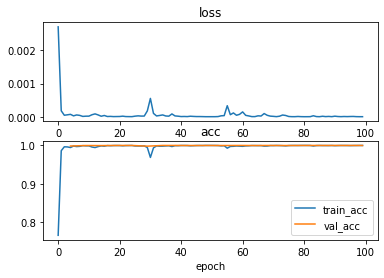

In [188]:
## training the model
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')
loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []

model = HybridSN(N_PCA,PATCH_SIZE,class_nums=NUM_CLASS)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = val_loader.dataset.__len__()

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
try:
    for e in tqdm(range(EPOCH), desc="Training:"):
        model.train()
        avg_loss = 0.
        train_acc = 0
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            data,target = data.to(device),target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            val_acc =0
            model.eval()
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                data,target = data.to(device),target.to(device)
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            torch.save(model.state_dict(),save_name)
    ax1.plot(np.arange(e+1),loss_list)
    ax1.set_title('loss')
    ax1.set_xlabel('epoch')
    ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
    ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
    ax2.set_title('acc')
    ax2.set_xlabel('epoch')
    ax2.legend()
except Exception as exc:
    print(exc)
finally: 
    print(f'Stop in epoch {e}')


In [189]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path):
    """get best model path by valuation list

    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir

    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    for f in os.listdir(save_path):
        if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
            os.remove(os.path.join(save_path,f))
    return best_model_path

best model:epoch_99_acc_1.0000.pth


  0%|          | 0/434 [00:00<?, ?it/s]

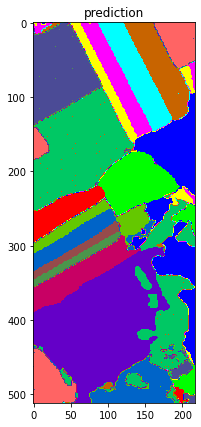

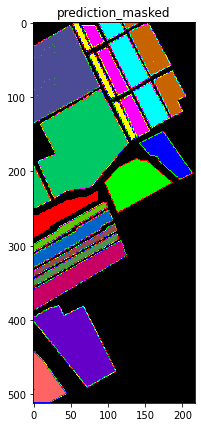

In [190]:
## inferring the whole image
##load best model
best_model_path = get_best_model(val_acc_list,val_epoch_list,SAVE_PATH)
best_model = HybridSN(N_PCA,PATCH_SIZE,class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(best_model_path))
## inference
best_model.to(device)
best_model.eval()
pred_map = []
for batch_idx, data in tqdm(enumerate(all_loader),total=len(all_loader)):
    data = data.to(device)
    target = best_model(data)
    _, pred = torch.max(target, dim = 1)
    pred_map += [np.array(pred.detach().cpu() + 1)]   ## class 0 in pred_map is class 1 in gt
pred_map = np.asarray(np.hstack(pred_map),dtype=np.uint8).reshape(label.shape[0],label.shape[1])
spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
spectral.imshow(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction.jpg"),pred_map,colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction_masked.jpg"),pred_map*(label!=0),colors = spectral.spy_colors)

In [191]:
## classfication report
test_pred = pred_map[test_gt!=0]
test_true = test_gt[test_gt!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'classfication_report.txt'),'w+')
fp.writelines(report_log)
fp.close()

OA: 1.0
AA: 1.0
Kappa: 1.0
                       precision    recall  f1-score   support

Brocoli_green_weeds_1     1.0000    1.0000    1.0000      1205
Brocoli_green_weeds_2     1.0000    1.0000    1.0000      2236
               Fallow     1.0000    1.0000    1.0000      1186
    Fallow_rough_plow     1.0000    1.0000    1.0000       837
        Fallow_smooth     1.0000    1.0000    1.0000      1607
              Stubble     1.0000    1.0000    1.0000      2375
               Celery     1.0000    1.0000    1.0000      2147
     Grapes_untrained     1.0000    1.0000    1.0000      6763
 Soil_vinyard_develop     1.0000    1.0000    1.0000      3722
  Corn_senesced_green     1.0000    1.0000    1.0000      1967
  Lettuce_romaine_4wk     1.0000    1.0000    1.0000       641
  Lettuce_romaine_5wk     1.0000    1.0000    1.0000      1156
  Lettuce_romaine_6wk     1.0000    1.0000    1.0000       549
  Lettuce_romaine_7wk     1.0000    1.0000    1.0000       642
    Vinyard_untrained     1